# Labeled Dataset Preprocessing and EDA

This notebook performs preprocessing on the manually labeled dataset of social media comments, filters and cleans data, encodes labels, splits into train/validation/test sets, and conducts exploratory data analysis.

Input: `manually_labeled.jsonl`
Output: `manually_labeled_cleaned.jsonl`


In [ ]:
# Install required packages (uncomment if needed)
# !pip install scikit-learn matplotlib seaborn

In [1]:
import json
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_path = '/content/drive/MyDrive/manually_labeled.jsonl'
data = []
with open(input_path, 'r', encoding='utf-8') as f:
    for line in f:
        entry = json.loads(line)
        data.append(entry)

print(f"Total raw labeled comments: {len(data)}")

Total raw labeled comments: 3548


## Preprocessing Steps

1. **Data Cleaning and Filtering:** Remove empty comments, entries with invalid labels, or fewer than three words.
2. **Contextual Input Structuring:** Combine post text and comment text.
3. **Label Encoding:** Convert labels to integers (Negative→0, Neutral→1, Positive→2).
4. **Train–Validation–Test Split:** Stratified split ensuring balanced classes.


In [5]:
# Define cleaning and filtering function
def clean_entry(entry):
    text = entry.get('comment_text', '').strip()
    post_text = entry.get('post_text', '').strip()
    label = entry.get('label', '').strip().lower()

    # Validate label
    if label not in ['negative', 'neutral', 'positive']:
        return None

    # Remove comments with fewer than 3 words
    if len(text.split()) < 3:
        return None

    # Build contextual input
    context = f"Post: {post_text}\nComment: {text}"
    entry['context'] = context
    entry['word_len'] = len(text.split())
    return entry

# Apply cleaning
cleaned_data = []
for entry in data:
    cleaned = clean_entry(entry)
    if cleaned is not None:
        cleaned_data.append(cleaned)

print(f"Retained after cleaning: {len(cleaned_data)}")

Retained after cleaning: 3457


In [6]:
df = pd.DataFrame(cleaned_data)

# Label encoding mapping
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
# Use the correct column name 'label' instead of 'sentiment'
df['label_encoded'] = df['label'].map(label_mapping)

# Save cleaned dataset to JSONL
output_path = '/content/drive/MyDrive/manually_labeled_cleaned2.jsonl'
with open(output_path, 'w', encoding='utf-8') as out:
    for _, row in df.iterrows():
        entry = {
            # Include all keys from the example output
            'comment_text': row.get('comment_text'),
            'platform': row.get('platform'),
            'post_id': row.get('post_id'),
            'post_title': row.get('post_title'),
            'post_url': row.get('post_url'),
            'timestamp': row.get('timestamp'),
            'character_count': len(row.get('comment_text', '')),
            'word_count': len(row.get('comment_text', '').split()),
            'label': row.get('label'),
        }
        out.write(json.dumps(entry) + '\n')

print(f"Saved cleaned data to {output_path}")


Saved cleaned data to /content/drive/MyDrive/manually_labeled_cleaned2.jsonl


In [8]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30, # 30% goes to temp (validation+test)
    stratify=df['label_encoded'],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # 50% of temp_df makes it 15% of original
    stratify=temp_df['label_encoded'],
    random_state=42
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Optionally save splits
train_df.to_json('train_labeled.jsonl', orient='records', lines=True)
val_df.to_json('val_labeled.jsonl', orient='records', lines=True)
test_df.to_json('test_labeled.jsonl', orient='records', lines=True)


Training set size: 2419
Validation set size: 519
Test set size: 519


## Exploratory Data Analysis

### 1. Sentiment Distribution
Pie chart showing the distribution of sentiment classes in the cleaned dataset.


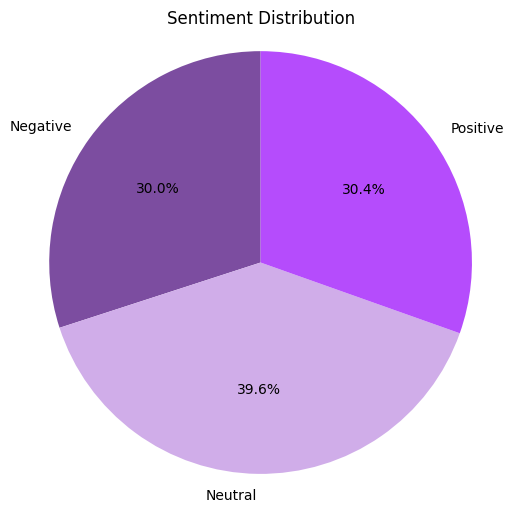

In [11]:
sentiment_counts = df['label'].value_counts().reindex(['negative', 'neutral', 'positive'])

# Define colors for each label
colors = ['#7c4da0', '#d0ade9', '#b54cfc'] # negative, neutral, positive

# Plot pie chart with specified colors
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index.str.capitalize(),
    autopct='%1.1f%%',
    startangle=90,
    colors=colors # Use the defined colors
)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

### 2. Sentiment Distribution by Platform
Bar chart showing the count of each sentiment for each platform.

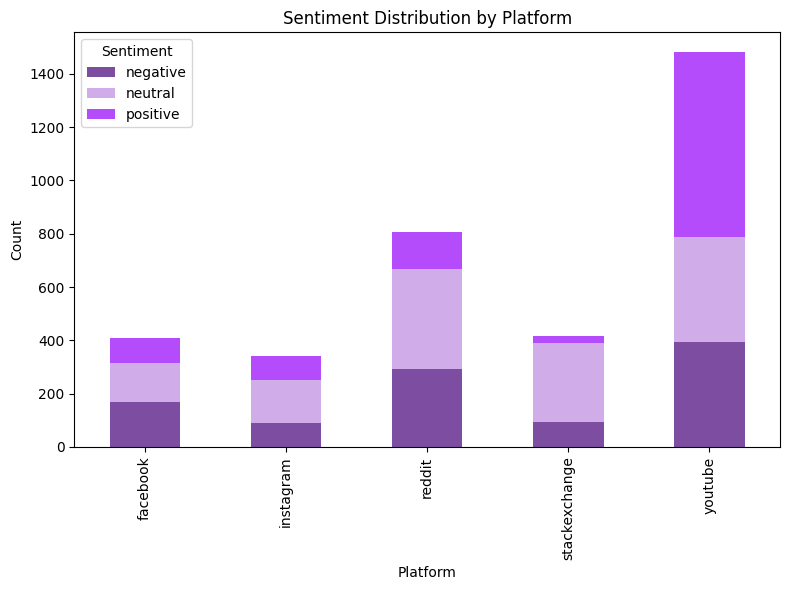

In [15]:
# Set platform as index for plotting
platform_sentiment = df.groupby(['platform', 'label']).size().unstack(fill_value=0)

# Define the color palette
colors = ['#7c4da0', '#d0ade9', '#b54cfc']  # negative, neutral, positive

# Plot stacked bar chart
platform_sentiment[['negative', 'neutral', 'positive']].plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6),
    color=colors
)

# Customize the plot
plt.title('Sentiment Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.tight_layout()

### 3. Comment Length Distribution by Sentiment
Boxplot showing distribution of comment word lengths for each sentiment category.

<ipython-input-20-6d25483e21a2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_len', data=df, order=['negative', 'neutral', 'positive'], palette="Purples")


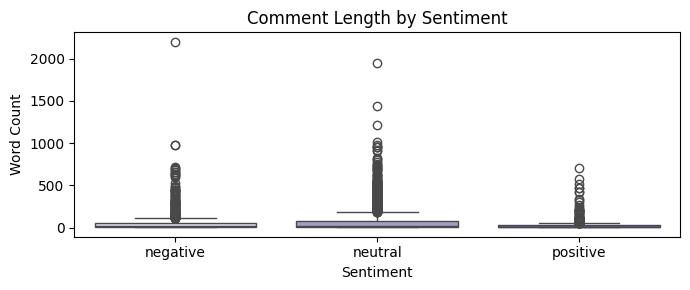

In [20]:
plt.figure(figsize=(7, 3))
sns.boxplot(x='label', y='word_len', data=df, order=['negative', 'neutral', 'positive'], palette="Purples")
plt.title('Comment Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()

### 4. Summary Statistics
Basic descriptive statistics for word lengths by sentiment.

In [22]:
df[['word_len', 'label_encoded']].groupby(df['label']).describe()

word_len                                                        \
            count       mean         std  min   25%   50%   75%     max   
label                                                                     
negative   1037.0  59.606557  125.692704  3.0  10.0  21.0  50.0  2201.0   
neutral    1368.0  87.764620  166.082017  3.0   9.0  18.0  78.5  1949.0   
positive   1052.0  26.565589   52.418778  3.0   7.0  14.0  26.0   703.0   

         label_encoded                                     
                 count mean  std  min  25%  50%  75%  max  
label                                                      
negative        1037.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
neutral         1368.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
positive        1052.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0